In this post, we look at AutoPyTorch, a framework for automated machine learning.

In [144]:
import os
import tempfile as tmp
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import sklearn.datasets
import sklearn.model_selection

os.environ['JOBLIB_TEMP_FOLDER'] = tmp.gettempdir()
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)


In [125]:
from autoPyTorch.api.tabular_regression import TabularRegressionTask

In [174]:
X, y = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    y,
    random_state=1,
)

# Obtain training and validation data
X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(
    X_train,
    y_train,
    random_state=1,
)


In [127]:
X_train.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
52,-0.052738,-0.044642,-0.009439,-0.005671,0.039710,0.044719,0.026550,-0.002592,-0.018118,-0.013504
121,0.063504,-0.044642,0.017506,0.021872,0.008063,0.021546,-0.036038,0.034309,0.019908,0.011349
170,0.023546,0.050680,-0.020218,-0.036656,-0.013953,-0.015092,0.059685,-0.039493,-0.096433,-0.017646
287,0.045341,-0.044642,-0.006206,-0.015999,0.125019,0.125198,0.019187,0.034309,0.032433,-0.005220
397,0.052606,-0.044642,-0.004050,-0.030918,-0.046975,-0.058307,-0.013948,-0.025840,0.036056,0.023775


In [128]:
y_train.head()

52      59.0
121    173.0
170     47.0
287    219.0
397    198.0
Name: target, dtype: float64

In [129]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(random_state=1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred_rf))

62.77500577100372

In [130]:
pred_df = pd.DataFrame({"rf": y_pred_rf, "true": y_test})
pred_df.head()

,rf,true
246,140.76,78.0
425,109.89,152.0
293,161.93,200.0
31,70.81,59.0
359,150.91,311.0


In [131]:
# Use validation dataset to find best hyperparameters for RF
rf = RandomForestRegressor(random_state=1)
hyperparameters = {"n_estimators": [10, 100, 1000], "max_depth": [1, 5, 10]}

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(rf, hyperparameters, cv=5, scoring="neg_root_mean_squared_error")
grid_search.fit(X_valid, y_valid)

grid_search.best_params_



{'max_depth': 5, 'n_estimators': 100}

In [132]:
# Train the RF model using the best hyperparameters on train + validation data

rf = RandomForestRegressor(**grid_search.best_params_, random_state=1)
# Combine train and validation data
X_train_overall = pd.concat([X_train, X_valid])
y_train_overall = pd.concat([y_train, y_valid])
rf.fit(X_train_overall, y_train_overall)
y_pred_rf = rf.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred_rf))

61.69476644955032

In [133]:
api = TabularRegressionTask()

# Do an api search without any memory limit but use only MLPs

api.search(
    X_train=X_train_overall,
    y_train=y_train_overall,
    X_test=X_test.copy(),
    y_test=y_test.copy(),
    optimize_metric='r2',
    total_walltime_limit=80,
    func_eval_time_limit_secs=10,
    dataset_name="Diabetes",
    memory_limit=None,
    enable_traditional_pipeline=True,
    )

*** SIGTERM received at time=1677497304 ***
PC: @        0x1850fb525  (unknown)  c10::function_ref<>::callback_fn<>()
    @        0x19bd2a6a4  (unknown)  absl::lts_20211102::WriteFailureInfo()
    @        0x19bd2a40b  (unknown)  absl::lts_20211102::AbslFailureSignalHandler()
    @     0x7ff81b110c1d  (unknown)  _sigtramp
    @     0x7fc8672c08e0  (unknown)  0x0
    @        0x180d49487  (unknown)  at::TensorIteratorBase::serial_for_each()
    @        0x1850f5f69  (unknown)  at::native::(anonymous namespace)::mul_kernel()
    @        0x181ca9801  (unknown)  at::(anonymous namespace)::wrapper_mul__Tensor()
    @        0x183a4bf3f  (unknown)  c10::impl::wrap_kernel_functor_unboxed_<>::call()
    @        0x183102ce8  (unknown)  c10::impl::wrap_kernel_functor_unboxed_<>::call()
    @        0x181670a79  (unknown)  at::_ops::mul__Tensor::call()
    @        0x1762fd145  (unknown)  torch::autograd::THPVariable_mul_()
    @        0x1030ddfe0  (unknown)  method_vectorcall_VARARGS_KEYWORD

PC: @     0x7ff81b0aa11a  (unknown)  __psynch_cvwait
    @        0x19bd2a6a4  (unknown)  absl::lts_20211102::WriteFailureInfo()
    @        0x19bd2a40b  (unknown)  absl::lts_20211102::AbslFailureSignalHandler()
    @     0x7ff81b110c1d  (unknown)  _sigtramp
    @        0x1995c5b28  (unknown)  0x0
    @        0x10326a78d  (unknown)  PyThread_acquire_lock_timed
    @        0x1032cd380  (unknown)  acquire_timed
    @        0x1032cd50d  (unknown)  lock_PyThread_acquire_lock
    @        0x1030ddfe0  (unknown)  method_vectorcall_VARARGS_KEYWORDS
    @        0x1031e78a8  (unknown)  _PyEval_EvalFrameDefault
    @        0x1030ce96a  (unknown)  _PyFunction_Vectorcall
    @        0x1031ea4b4  (unknown)  _PyEval_EvalFrameDefault
    @        0x1030cecab  (unknown)  _PyFunction_Vectorcall
    @        0x1030d3c3e  (unknown)  method_vectorcall
    @        0x1031e6daa  (unknown)  _PyEval_EvalFrameDefault
    @        0x1030ce96a  (unknown)  _PyFunction_Vectorcall
    @        0x1031e78a8  

In [134]:
y_pred = api.predict(X_test)
score = api.score(y_pred, y_test)
print(score)
np.sqrt(mean_squared_error(y_test, y_pred))

{'r2': 0.3195282683852355}


59.60580312650306

In [14]:
# Print statistics from search
print(api.sprint_statistics())

autoPyTorch results:
	Dataset name: Diabetes
	Optimisation Metric: r2
	Best validation score: 0.4352600925944532
	Number of target algorithm runs: 18
	Number of successful target algorithm runs: 14
	Number of crashed target algorithm runs: 2
	Number of target algorithms that exceeded the time limit: 2
	Number of target algorithms that exceeded the memory limit: 0



In [15]:
api.get_models_with_weights()[0]

(0.6000000000000001,
 MyTraditionalTabularRegressionPipeline(config='random_forest',
                                        dataset_properties={'categorical_columns': [],
                                                            'categories': [],
                                                            'input_shape': (10,),
                                                            'is_small_preprocess': True,
                                                            'issigned': True,
                                                            'issparse': False,
                                                            'numerical_columns': [0,
                                                                                  1,
                                                                                  2,
                                                                                  3,
                                                                                  

In [16]:
api.get_models_with_weights()[1]

(0.16000000000000003,
 MyTraditionalTabularRegressionPipeline(config='svm',
                                        dataset_properties={'categorical_columns': [],
                                                            'categories': [],
                                                            'input_shape': (10,),
                                                            'is_small_preprocess': True,
                                                            'issigned': True,
                                                            'issparse': False,
                                                            'numerical_columns': [0,
                                                                                  1,
                                                                                  2,
                                                                                  3,
                                                                                  4,
      

In [17]:
api.get_models_with_weights()[2]

(0.12000000000000001,
 ________________________________________
 	TabularRegressionPipeline
 ________________________________________
 0-) imputer: 
 	SimpleImputer
 
 1-) variance_threshold: 
 	VarianceThreshold
 
 2-) coalescer: 
 	NoCoalescer
 
 3-) encoder: 
 	NoEncoder
 
 4-) scaler: 
 	StandardScaler
 
 5-) feature_preprocessor: 
 	NoFeaturePreprocessor
 
 6-) tabular_transformer: 
 	TabularColumnTransformer
 
 7-) preprocessing: 
 	EarlyPreprocessing
 
 8-) network_embedding: 
 	autoPyTorch.pipeline NoEmbedding
 
 9-) network_backbone: 
 	autoPyTorch.pipeline ShapedMLPBackbone
 
 10-) network_head: 
 	autoPyTorch.pipeline FullyConnectedHead
 
 11-) network: 
 	Sequential ({'random_state': RandomState(MT19937) at 0x19708F440, '_fit_requirements': [FitRequirement(name='network_head', supported_types=(<class 'torch.nn.modules.module.Module'>,), user_defined=False, dataset_property=False), FitRequirement(name='network_backbone', supported_types=(<class 'torch.nn.modules.module.Modul

What if we fit only NNs?

In [18]:
api2 = TabularRegressionTask(seed=2, ensemble_size=0)

api2.search(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test.copy(),
    y_test=y_test.copy(),
    optimize_metric='r2',
    total_walltime_limit=40,
    func_eval_time_limit_secs=10,
    dataset_name="Diabetes",
    memory_limit=None,
    enable_traditional_pipeline=False,
    )


[WARNING] [2023-02-27 15:46:02,125:Client-autoPyTorch.automl_common.common.utils.backend] Directory /var/folders/1x/wmgn24mn1bbd2vgbqlk98tbc0000gn/T/autoPyTorch_tmp_a7a1276c-b687-11ed-9799-3c7d0a00e5d9/.autoPyTorch/ensembles does not exist
[ERROR] [2023-02-27 15:46:02,126:Client-AutoPyTorch:Diabetes:2] No valid ensemble was created. Please check the logfile for errors. Default to the best individual estimator:[(2, 2, 5.555555555555555)]
NoneType: None


In [19]:
y_pred2 = api2.predict(X_test)
score2 = api2.score(y_pred2, y_test)
score2

{'r2': -0.37656772470491995}

In [20]:
np.sqrt(mean_squared_error(y_test, y_pred2))

84.77782906691597

Okay, it seems we are worse than the random forest. Let's see what happened.

In [21]:
api2.get_models_with_weights()[0]

(1.0,
 ________________________________________
 	TabularRegressionPipeline
 ________________________________________
 0-) imputer: 
 	SimpleImputer
 
 1-) variance_threshold: 
 	VarianceThreshold
 
 2-) coalescer: 
 	NoCoalescer
 
 3-) encoder: 
 	NoEncoder
 
 4-) scaler: 
 	StandardScaler
 
 5-) feature_preprocessor: 
 	NoFeaturePreprocessor
 
 6-) tabular_transformer: 
 	TabularColumnTransformer
 
 7-) preprocessing: 
 	EarlyPreprocessing
 
 8-) network_embedding: 
 	autoPyTorch.pipeline NoEmbedding
 
 9-) network_backbone: 
 	autoPyTorch.pipeline ShapedMLPBackbone
 
 10-) network_head: 
 	autoPyTorch.pipeline FullyConnectedHead
 
 11-) network: 
 	Sequential ({'random_state': RandomState(MT19937) at 0x19757CE40, '_fit_requirements': [FitRequirement(name='network_head', supported_types=(<class 'torch.nn.modules.module.Module'>,), user_defined=False, dataset_property=False), FitRequirement(name='network_backbone', supported_types=(<class 'torch.nn.modules.module.Module'>,), user_defi

In [146]:
import torch
X_train_torch = torch.from_numpy(X_train.values).float()
y_train_torch = torch.from_numpy(y_train.values).float()
X_val_torch = torch.from_numpy(X_valid.values).float()
y_val_torch = torch.from_numpy(y_valid.values).float()
X_test_torch = torch.from_numpy(X_test.values).float()
y_test_torch = torch.from_numpy(y_test.values).float()

In [147]:
# Build a simple MLP in PyTorch, train on training data and optimize on validation data


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self, l1 = 64, l2 = 64, l3 = 64, l2_reg = 0.0):
        super(Net, self).__init__()
        self.l2_reg = l2_reg
        self.fc1 = nn.Linear(10, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, l3)
        self.fc4 = nn.Linear(l3, 1)

    def forward(self, x):
        # Add a residual connection
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    

net = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)



train_losses = []
val_losses = []
test_losses = []


for epoch in range(1000):  # loop over the dataset multiple times and store the train, test loss
    optimizer.zero_grad()
    outputs = net(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    # Add L2 regularization
    for param in net.parameters():
        loss += net.l2_reg * torch.norm(param)
    loss.backward()
    optimizer.step()

    train_losses.append(np.sqrt(loss.item()))
    val_losses.append(np.sqrt(criterion(net(X_val_torch), y_val_torch).item()))
    test_losses.append(np.sqrt(criterion(net(X_test_torch), y_test_torch).item()))
            
print('Finished Training')


Finished Training


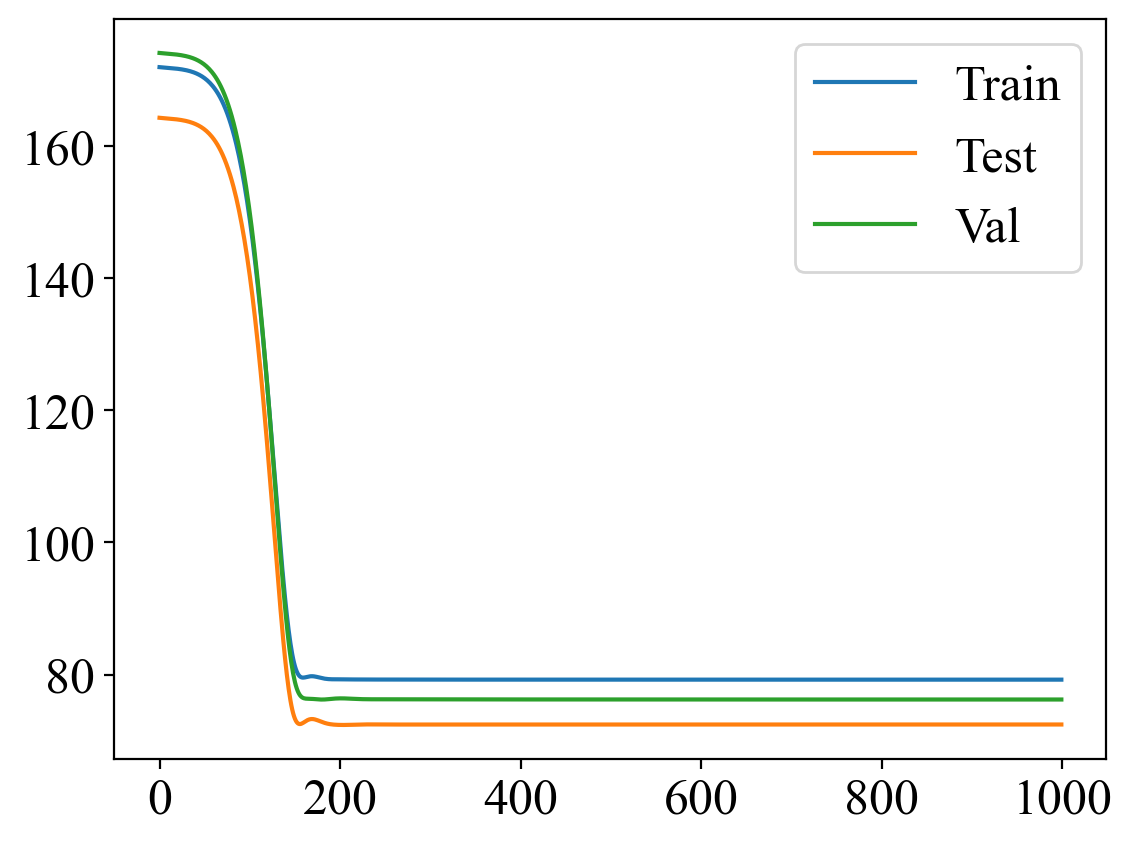

In [148]:
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.plot(val_losses, label="Val")
plt.legend()

In [149]:
with torch.no_grad():
    outputs = net(X_test_torch)
    loss = criterion(outputs, y_test_torch)
    print(f"Test loss: {np.sqrt(loss.item())}")
    outputs = net(X_train_torch)    
    loss = criterion(outputs, y_train_torch)
    print(f"Train loss: {np.sqrt(loss.item())}")
    print("")


Test loss: 72.43338130007807
Train loss: 79.22518156830725



In [175]:
# Fit the NN model using scaled y values
# Using sklearn's StandardScaler to scale the y values

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_train_scaled = torch.from_numpy(y_train_scaled).float()
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))
y_test_scaled = torch.from_numpy(y_test_scaled).float()
y_valid_scaled = scaler.transform(y_valid.values.reshape(-1, 1))
y_valid_scaled = torch.from_numpy(y_valid_scaled).float()

net = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

train_losses = []
val_losses = []
test_losses = []


for epoch in range(3000):  # loop over the dataset multiple times and store the train, test loss
    optimizer.zero_grad()
    outputs = net(X_train_torch)
    loss = criterion(outputs, y_train_scaled)
    # Add L2 regularization
    for param in net.parameters():
        loss += net.l2_reg * torch.norm(param)
    loss.backward()
    optimizer.step()

    train_losses.append(np.sqrt(loss.item()))

            
print('Finished Training')



Finished Training


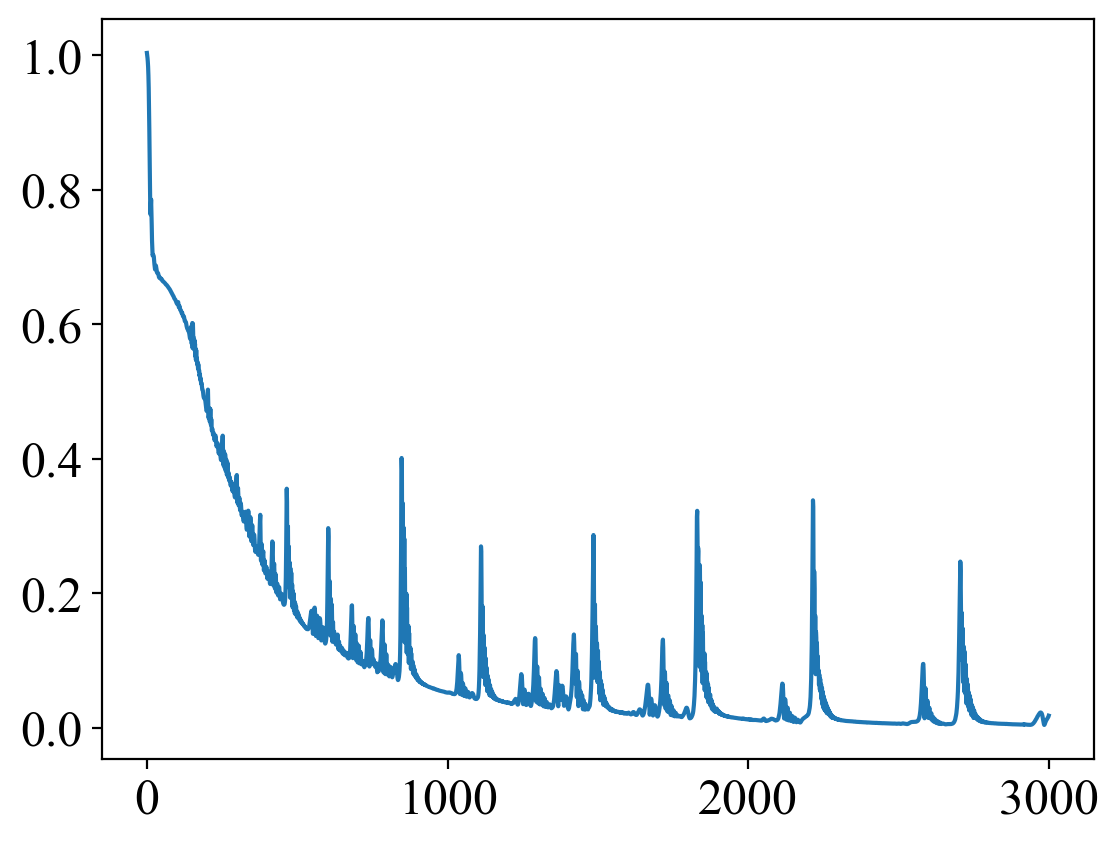

In [176]:
plt.plot(train_losses, label="Train")

In [177]:
# Predict the scaled y values and inverse transform them to get the original y values

with torch.no_grad():
    outputs = net(X_test_torch)

In [178]:
# Inverse transform the scaled y values to get the original y values

y_pred = scaler.inverse_transform(outputs.numpy())
y_pred = y_pred.reshape(-1)
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")

Test RMSE: 87.33749596057267


<AxesSubplot: xlabel='y_test', ylabel='y_pred'>

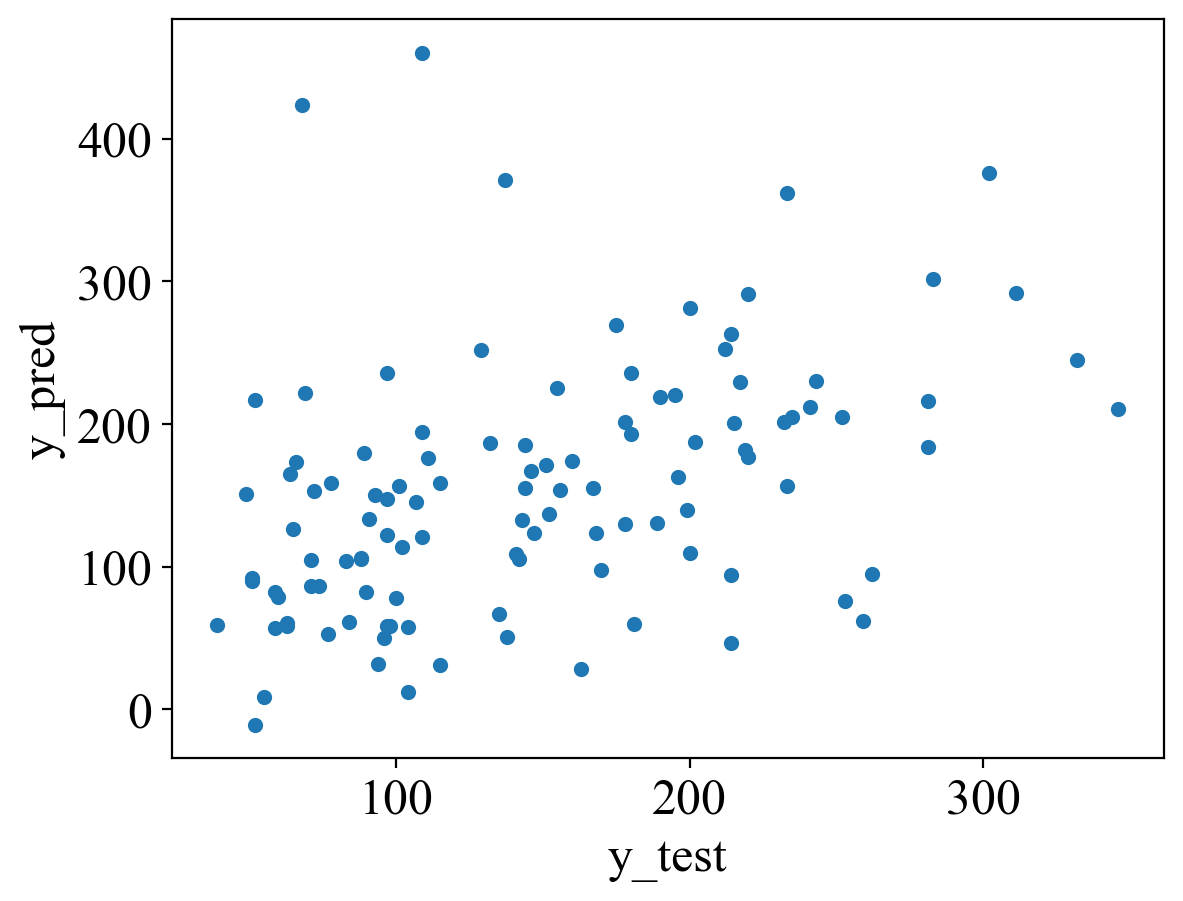

In [179]:
pd.DataFrame({"y_test": y_test, "y_pred": y_pred}).plot.scatter(x="y_test", y="y_pred")

In [180]:
# At this point it seems our model is worse than RF, Auto model containing Catboost etc. Let us optimize our NN
# I will use Ray Tune to optimize the hyperparameters

import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

def train_mlp(config):
    net = Net(config["l1"], config["l2"], config["l3"], config["l2_reg"])
    
    criterion = nn.MSELoss()
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=config["lr"])
    for epoch in range(1000):  # loop over the dataset multiple times and store the train, test loss
        optimizer.zero_grad()
        outputs = net(X_train_torch)
        loss = criterion(outputs, y_train_scaled)
        # Add l2 regularization to loss
        l2_reg = torch.tensor(0.)
        for param in net.parameters():
            l2_reg += torch.norm(param)
        loss += config["l2_reg"] * l2_reg
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        outputs = net(X_val_torch)
        # Inverse transform the scaled y values to get the original y values
        y_pred = scaler.inverse_transform(outputs.numpy())
        loss = np.sqrt(mean_squared_error(y_valid, y_pred))
        return {"loss": loss, "status": "ok"}


In [181]:
ray.shutdown()

ray.init()
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=100,
    grace_period=1,
    reduction_factor=2)

reporter = CLIReporter(
    parameter_columns=["l1", "l2", "l3", "lr", "l2_reg"],
    metric_columns=["loss", "training_iteration"])

analysis = tune.run(
    train_mlp,
    resources_per_trial={"cpu": 1},
    config={
        "l1": tune.choice([2, 4, 16, 32, 64, 128, 256]),
        "l2": tune.choice([2, 4, 16, 32, 64, 128, 256]),
        "l3": tune.choice([2, 4, 16, 32, 64, 128, 256]),
        "l2_reg": tune.loguniform(1e-4, 1.0),
        "lr": tune.loguniform(1e-4, 1.0),
    },
    num_samples=50,
    scheduler=scheduler,
    progress_reporter=reporter)



Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,loss,node_ip,pid,status,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_mlp_35f59_00000,2023-02-27_17-36-54,True,,39e261fb732642929a52fdc97976aee5,"0_l1=128,l2=4,l2_reg=0.3756,l3=32,lr=0.0317",Nipuns-iMac-8.local,1,76.2344,127.0.0.1,89828,ok,2.82443,2.82443,2.82443,1677499614,0,,1,35f59_00000,0.00215197
train_mlp_35f59_00001,2023-02-27_17-37-01,True,,a503329c351c43429598bbfd138bb8f6,"1_l1=4,l2=2,l2_reg=0.0129,l3=2,lr=0.0680",Nipuns-iMac-8.local,1,76.212,127.0.0.1,89833,ok,2.99838,2.99838,2.99838,1677499621,0,,1,35f59_00001,0.0209732
train_mlp_35f59_00002,2023-02-27_17-37-02,True,,4698857106a748a2be56befc6bb9ace1,,Nipuns-iMac-8.local,1,76.2122,127.0.0.1,89834,ok,3.37268,3.37268,3.37268,1677499622,0,,1,35f59_00002,0.0184102
train_mlp_35f59_00003,2023-02-27_17-37-03,True,,6bd8a679f4a44679b53483e52891389b,"3_l1=32,l2=4,l2_reg=0.4648,l3=256,lr=0.0269",Nipuns-iMac-8.local,1,76.2066,127.0.0.1,89835,ok,4.65682,4.65682,4.65682,1677499623,0,,1,35f59_00003,0.0225301
train_mlp_35f59_00004,2023-02-27_17-37-02,True,,3581107a516f4bf4b18826a6a8ad33ed,"4_l1=32,l2=16,l2_reg=0.0007,l3=2,lr=0.0009",Nipuns-iMac-8.local,1,54.6544,127.0.0.1,89836,ok,3.15386,3.15386,3.15386,1677499622,0,,1,35f59_00004,0.023632
train_mlp_35f59_00005,2023-02-27_17-37-02,True,,8339bd9177fb40a9a47cae442d7e3654,"5_l1=2,l2=16,l2_reg=0.0002,l3=64,lr=0.0727",Nipuns-iMac-8.local,1,60.5804,127.0.0.1,89838,ok,3.44994,3.44994,3.44994,1677499622,0,,1,35f59_00005,0.0128722
train_mlp_35f59_00006,2023-02-27_17-37-02,True,,d1431c1d6f1440fe873a9d6be9f9711c,"6_l1=2,l2=64,l2_reg=0.0011,l3=32,lr=0.0030",Nipuns-iMac-8.local,1,54.3501,127.0.0.1,89843,ok,3.61302,3.61302,3.61302,1677499622,0,,1,35f59_00006,0.0113921
train_mlp_35f59_00007,2023-02-27_17-37-03,True,,8612e489162c4c12ab96d304abee66c8,"7_l1=4,l2=64,l2_reg=0.9859,l3=128,lr=0.0117",Nipuns-iMac-8.local,1,76.207,127.0.0.1,89844,ok,4.48812,4.48812,4.48812,1677499623,0,,1,35f59_00007,0.00788832
train_mlp_35f59_00008,2023-02-27_17-37-03,True,,6ef63a35bb36442cbc929b64162ad3d2,"8_l1=256,l2=16,l2_reg=0.0280,l3=2,lr=0.0224",Nipuns-iMac-8.local,1,51.8603,127.0.0.1,89845,ok,4.82484,4.82484,4.82484,1677499623,0,,1,35f59_00008,0.00866914
train_mlp_35f59_00009,2023-02-27_17-37-02,True,,82741428b6dd47dca2f00c994cd3665e,"9_l1=16,l2=64,l2_reg=0.0022,l3=2,lr=0.0007",Nipuns-iMac-8.local,1,55.3347,127.0.0.1,89846,ok,3.37007,3.37007,3.37007,1677499622,0,,1,35f59_00009,0.0235229


2023-02-27 17:37:15,412	INFO tune.py:762 -- Total run time: 27.43 seconds (27.16 seconds for the tuning loop).


In [182]:
# Print the table for all the trials
df = analysis.results_df

# Sort the table by loss
df.sort_values(by="loss", inplace=True)

# Show only loss, config/l1, config/l2, config/l3, config/lr, training_iteration
df[["loss", "config/l1", "config/l2", "config/l3", "config/lr", "config/l2_reg"]]

,loss,config/l1,config/l2,config/l3,config/lr,config/l2_reg
trial_id,,,,,,
35f59_00008,51.860286,256,16,2,0.022433,0.028044
35f59_00044,51.926864,128,4,64,0.001139,0.031031
35f59_00034,53.705805,128,2,4,0.000778,0.001340
35f59_00013,54.242451,4,32,4,0.001241,0.000884
35f59_00006,54.350125,2,64,32,0.002993,0.001127
35f59_00004,54.654366,32,16,2,0.000930,0.000685
35f59_00009,55.334703,16,64,2,0.000653,0.002193
35f59_00035,58.680090,4,16,256,0.068746,0.000939
35f59_00005,60.580389,2,16,64,0.072716,0.000170


In [183]:
# Print the best hyperparameters

analysis.get_best_config(metric="loss", mode="min")

{'l1': 256,
 'l2': 16,
 'l3': 2,
 'l2_reg': 0.02804441527734549,
 'lr': 0.02243305160125706}

In [184]:
# Perform the final test on the test set

best_config = analysis.get_best_config(metric="loss", mode="min")

# Use the best hyperparameters to train the model
net = Net(best_config["l1"], best_config["l2"], best_config["l3"], best_config["l2_reg"])
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=best_config["lr"])
for epoch in range(1000):  # loop over the dataset multiple times and store the train, test loss
    optimizer.zero_grad()
    outputs = net(X_train_torch)
    loss = criterion(outputs, y_train_scaled)
    # Add L2 regularization
    for param in net.parameters():
        loss += net.l2_reg * torch.norm(param)

    
    loss.backward()
    optimizer.step()

with torch.no_grad():
    outputs = net(X_test_torch)
    # Inverse transform the scaled y values to get the original y values
    y_pred = scaler.inverse_transform(outputs.numpy())
    loss = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Test RMSE: {loss}")
    print("")
    

Test RMSE: 72.44006516868477



In [185]:
# Thus far it seems even with hyperparameter tuning we are unable to match the performance of ensemble models. 

# Get the top 5 configurations

df[['loss', 'config/l1', 'config/l2', 'config/l3', 'config/lr', 'config/l2_reg']].head(5)


,loss,config/l1,config/l2,config/l3,config/lr,config/l2_reg
trial_id,,,,,,
35f59_00008,51.860286,256,16,2,0.022433,0.028044
35f59_00044,51.926864,128,4,64,0.001139,0.031031
35f59_00034,53.705805,128,2,4,0.000778,0.001340
35f59_00013,54.242451,4,32,4,0.001241,0.000884
35f59_00006,54.350125,2,64,32,0.002993,0.001127


In [186]:
config_list_of_dicts = df[['config/l1', 'config/l2', 'config/l3', 'config/lr', 'config/l2_reg']].head(5).to_dict('records')

# Train an ensemble of 5 models using the top 5 configurations

ensemble = []
for config in config_list_of_dicts:
    net = Net(config["config/l1"], config["config/l2"], config["config/l3"], config["config/l2_reg"])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=config["config/lr"])
    for epoch in range(2000):  # loop over the dataset multiple times and store the train, test loss
        optimizer.zero_grad()
        outputs = net(X_train_torch)
        loss = criterion(outputs, y_train_scaled)
        # Add L2 regularization
        for param in net.parameters():
            loss += net.l2_reg * torch.norm(param)
        loss.backward()
        optimizer.step()
    ensemble.append(net)


In [188]:
# Get the predictions from the ensemble

ensemble_preds = []
for net in ensemble:
    with torch.no_grad():
        outputs = net(X_test_torch)
        # Scale the predictions back to the original scale
        outputs = scaler.inverse_transform(outputs.numpy())
        ensemble_preds.append(outputs)
    
ensemble_preds = np.array(ensemble_preds)

# Get the mean of the predictions

ensemble_preds_mean = ensemble_preds.mean(axis=0)

# Get the RMSE of the ensemble

criterion = nn.MSELoss()
loss = criterion(torch.tensor(ensemble_preds_mean), y_test_torch)
print(f"Test loss: {np.sqrt(loss.item())}")


Test loss: 79.81030060105807


## Inputs to Meta Learning model


### Data inputs

1. Input vector: X is of shape N, D where N is the number of samples and D is the number of features
2. Output vector: y is of shape N, 1

### Encoder inputs

3. Context vector: Containing C vectors of concatenated (X, y) pairs from the training set. Thus, shape of context vector is (C, D + 1)

### Encoder internals
-----------------
4. Encoding: Encoder is a neural network that takes in the context vector and outputs a vector of shape (C, E) where E is the encoding size

### Encoder outputs
---------------
5. Encoder summary: A vector of shape (E, ) that is the mean of the encoding

### Decoder inputs
--------------
6. Query vector: Containing Q vectors of X from test set. Thus, shape of query vector is (Q, D)
7. It also takes the encoder summary as input of size (E, ). But, we make Q copies of the encoder summary and concatenate it with the query vector to get a vector of shape (Q, E + D)

### Decoder outputs
-----------------
8. Decoding: Decoder is a neural network that takes in the query vector and encoder summary and outputs a vector of shape (Q, 1)


In [41]:
D = X_train_torch.shape[1]


In [82]:
# Building the encoder 
# Takes as input the number of features, the number of nodes in 3 hidden layers, and the L2 regularization parameter

class Encoder(nn.Module):
    def __init__(self, n_features = D+1, l1_size=32, l2_size=32, E = 32, l2_reg=0.0):
        super(Encoder, self).__init__()
        self.l1 = nn.Linear(n_features, l1_size)
        self.l2 = nn.Linear(l1_size, l2_size)
        self.l3 = nn.Linear(l2_size, E)
        self.l2_reg = l2_reg
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.relu(self.l2(x))
        x = self.relu(self.l3(x))
        return x


In [83]:
# Create C context vectors and pass them through the encoder

C = 5
Q = 2
encoder = Encoder(E=32)

# Create the context vectors input
C_idx = np.random.choice(X_train_torch.shape[0], C, replace=False)
C_idx = torch.tensor(C_idx)

# Get the Q query vectors
all_idx = np.arange(X_train_torch.shape[0])
Q_idx = np.random.choice(np.setdiff1d(all_idx, C_idx), Q, replace=False)
Q_idx = torch.tensor(Q_idx)

C_idx, Q_idx

(tensor([222, 206,  98, 156,  95]), tensor([243, 166]))

In [191]:
X_train_torch[C_idx], y_train_scaled[C_idx], y_train_torch[C_idx]

(tensor([[ 0.0090, -0.0446, -0.0321, -0.0263,  0.0425, -0.0104,  0.1591, -0.0764,
          -0.0119, -0.0384],
         [ 0.0054,  0.0507,  0.0348, -0.0011,  0.1525,  0.1988, -0.0618,  0.1852,
           0.0156,  0.0735],
         [-0.0382, -0.0446,  0.0671, -0.0608, -0.0291, -0.0232, -0.0103, -0.0026,
          -0.0015,  0.0196],
         [ 0.0453,  0.0507,  0.0606,  0.0311,  0.0287, -0.0473, -0.0544,  0.0712,
           0.1336,  0.1356],
         [-0.0709, -0.0446,  0.0391, -0.0332, -0.0126, -0.0345, -0.0250, -0.0026,
           0.0677, -0.0135]]),
 tensor([[-0.8287],
         [-0.8666],
         [-0.9423],
         [ 1.1656],
         [ 1.9860]]),
 tensor([ 87.,  84.,  78., 245., 310.]))

In [192]:
context_input = torch.cat((X_train_torch[C_idx], y_train_scaled[C_idx].reshape(-1, 1)), axis=1)
pd.DataFrame(context_input)

,0,1,2,3,4,5,6,7,8,9,10
0,0.009016,-0.044642,-0.032073,-0.026328,0.042462,-0.010395,0.159089,-0.076395,-0.011901,-0.038357,-0.828744
1,0.005383,0.050680,0.034751,-0.001080,0.152538,0.198788,-0.061809,0.185234,0.015567,0.073480,-0.866611
2,-0.038207,-0.044642,0.067085,-0.060757,-0.029088,-0.023234,-0.010266,-0.002592,-0.001499,0.019633,-0.942345
3,0.045341,0.050680,0.060618,0.031053,0.028702,-0.047347,-0.054446,0.071210,0.133599,0.135612,1.165576
4,-0.070900,-0.044642,0.039062,-0.033214,-0.012577,-0.034508,-0.024993,-0.002592,0.067736,-0.013504,1.986025


In [193]:
encoder(context_input).shape

torch.Size([5, 32])

In [194]:
encoder(context_input).mean(axis=0).shape


torch.Size([32])

In [195]:
# Now we will build the decoder

class Decoder(nn.Module):
    def __init__(self, E=32, l1_size=32, l2_size=32, l2_reg=0.0):
        super(Decoder, self).__init__()
        self.l1 = nn.Linear(E, l1_size)
        self.l2 = nn.Linear(l1_size, l2_size)
        self.l3 = nn.Linear(l2_size, 1)
        self.l2_reg = l2_reg
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.relu(self.l2(x))
        x = self.relu(self.l3(x))
        return x

In [196]:
# Pass Q query vectors and the context vectors through the decoder

decoder = Decoder(E =32 + D)
mean_context = encoder(context_input).mean(axis=0)
# Repeat the mean context vector Q times
mean_context = mean_context.repeat(Q, 1)
mean_context.shape

torch.Size([2, 32])

In [197]:
query = X_train_torch[Q_idx]
query.shape

torch.Size([2, 10])

In [198]:
input_decoder = torch.cat((query, mean_context), axis=1)
input_decoder.shape

torch.Size([2, 42])

In [199]:
decoder(input_decoder).shape

torch.Size([2, 1])

In [200]:
# Building a meta learning class

class Meta(nn.Module):
    def __init__(self, D = X_train_torch.shape[1], E = 32,  C = 10, Q = 2, l1_size=32, l2_size=32, l2_reg=0.0):
        super(Meta, self).__init__()
        self.encoder = Encoder(D + 1, l1_size, l2_size, E, l2_reg)
        self.decoder = Decoder(E + D, l1_size, l2_size, l2_reg)
        self.D = D
        self.E = E
        self.C = C
        self.Q = Q
        self.l2_reg = l2_reg

    def forward(self, context_input, query):
        mean_context = self.encoder(context_input).mean(axis=0)
        # Repeat the mean context vector Q times
        mean_context = mean_context.repeat(self.Q, 1)
        input_decoder = torch.cat((query, mean_context), axis=1)
        return self.decoder(input_decoder)


In [201]:
m = Meta()
m(context_input, query)

tensor([[0.],
        [0.]], grad_fn=<ReluBackward0>)

In [202]:
# Create a function to get the context and query vectors

def get_context_query(X, y, C, Q):
    C_idx = np.random.choice(X.shape[0], C, replace=False)
    C_idx = torch.tensor(C_idx)
    all_idx = np.arange(X.shape[0])
    Q_idx = np.random.choice(np.setdiff1d(all_idx, C_idx), Q, replace=False)
    Q_idx = torch.tensor(Q_idx)
    context_input = torch.cat((X[C_idx], y[C_idx].reshape(-1, 1)), axis=1)
    query = X[Q_idx]
    return context_input, query, y[Q_idx]

In [203]:
get_context_query(X_train_torch, y_train_torch, 10, 2)

(tensor([[ 8.1666e-02,  5.0680e-02,  1.3387e-03,  3.5644e-02,  1.2639e-01,
           9.1065e-02,  1.9187e-02,  3.4309e-02,  8.4495e-02, -3.0072e-02,
           1.9600e+02],
         [-5.2738e-02,  5.0680e-02, -1.1595e-02,  5.6301e-02,  5.6221e-02,
           7.2902e-02, -3.9719e-02,  7.1210e-02,  3.0566e-02, -5.2198e-03,
           1.8100e+02],
         [ 1.7505e-03, -4.4642e-02, -4.0503e-03, -5.6706e-03, -8.4487e-03,
          -2.3861e-02,  5.2322e-02, -3.9493e-02, -8.9440e-03, -1.3504e-02,
           8.8000e+01],
         [-6.3635e-02,  5.0680e-02,  9.6186e-02,  1.0450e-01, -2.9449e-03,
          -4.7585e-03, -6.5845e-03, -2.5923e-03,  2.2692e-02,  7.3480e-02,
           2.7400e+02],
         [-3.8207e-02, -4.4642e-02,  9.9612e-03, -4.6985e-02, -5.9359e-02,
          -5.2983e-02, -1.0266e-02, -3.9493e-02, -1.5998e-02, -4.2499e-02,
           2.1000e+02],
         [ 3.0811e-02,  5.0680e-02, -8.3616e-03,  4.6580e-03,  1.4942e-02,
           2.7496e-02,  8.1421e-03, -8.1274e-03, -2.952

In [204]:
# Training loop

train_loss = []
val_losses = []
test_losses = []
for i in range(2000):
    context_input, query, y_query = get_context_query(X_train_torch, y_train_scaled, 10, 2)
    y_pred = m(context_input, query)
    loss = criterion(y_pred, y_query)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    if i % 100 == 0:
        print(f"Epoch {i} - Train loss: {loss.item()}")



Epoch 0 - Train loss: 0.9213696718215942
Epoch 100 - Train loss: 0.4558916985988617
Epoch 200 - Train loss: 0.8285228610038757
Epoch 300 - Train loss: 1.2891581058502197
Epoch 400 - Train loss: 0.6848188042640686
Epoch 500 - Train loss: 1.267048954963684
Epoch 600 - Train loss: 1.5666141510009766
Epoch 700 - Train loss: 0.12341234087944031
Epoch 800 - Train loss: 1.0183466672897339
Epoch 900 - Train loss: 1.2150161266326904
Epoch 1000 - Train loss: 0.5613757371902466
Epoch 1100 - Train loss: 0.8400710821151733
Epoch 1200 - Train loss: 0.9052169919013977
Epoch 1300 - Train loss: 1.4312090873718262
Epoch 1400 - Train loss: 0.7862072587013245
Epoch 1500 - Train loss: 0.06718450784683228
Epoch 1600 - Train loss: 1.155807614326477
Epoch 1700 - Train loss: 1.9417030811309814
Epoch 1800 - Train loss: 0.8964922428131104
Epoch 1900 - Train loss: 0.1502131223678589


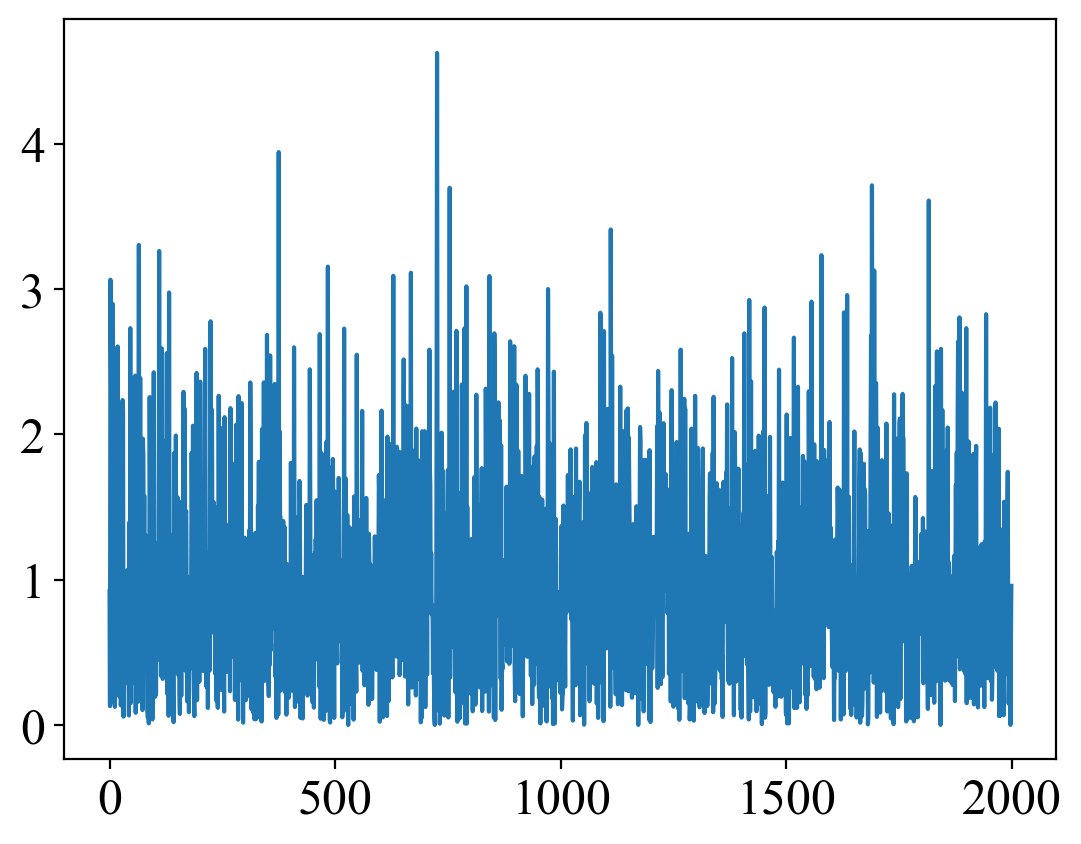

In [205]:
plt.plot(train_loss)

In [206]:
context_input, _, _ = get_context_query(X_train_torch, y_train_torch, 10, query.shape[0])
context_input.shape

torch.Size([10, 11])

In [207]:
X_test_torch.shape

torch.Size([111, 10])

In [208]:
query.shape

torch.Size([2, 10])

In [209]:
context_input.shape

torch.Size([10, 11])

In [210]:
# Use whole of the test set as the query set
query = X_test_torch
y_query = y_test_torch

# get context from the training set
context_input, _, _ = get_context_query(X_train_torch, y_train_torch, 10, query.shape[0])

m = Meta(C=10, Q=query.shape[0])

y_pred = m(context_input, query)

# Use inverse transform to get the original values

y_pred = scaler.inverse_transform(y_pred.detach().numpy())
print(f"Test loss: {np.sqrt(mean_squared_error(y_query, y_pred))}")


Test loss: 72.43473815917969


In [211]:
pd.DataFrame({"y_pred": y_pred.reshape(-1), "y_query": y_query})

,y_pred,y_query
0,152.657257,78.0
1,152.657257,152.0
2,152.657257,200.0
3,152.657257,59.0
4,152.657257,311.0
...,...,...
106,152.657257,281.0
107,152.657257,281.0
108,152.657257,214.0
109,152.657257,96.0
